In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# first of all, let us define some parameters
#
# size of the images
sx = 5000
sy = 5000
# number of sources on each image
nsrc1 = int( 0.1 * (sx*sy)/(sx+sy) )
#nsrc2 = int( 0.5 * nsrc1 )
# typical error radius (in pixels)
rerr1 = 20
rerr2 = rerr1

In [4]:
# generate coordinate pairs for each image
def generate_positions(npts,img_shape):
    """
    Generate 'npts' points uniformly across 'image_shape'.
    
    Args:
        npts      : number of points to generate
        img_shape : (y,x) shape where to generate points

    Returns:
        Pair_Coordinates_List : list of (y,x) tuples
    """
    import numpy as np
    _sy,_sx = img_shape
    assert _sy>=5 and _sx>=5 # because I want
    indy = np.random.randint(0,_sy-1,npts)
    indx = np.random.randint(0,_sx-1,npts)
    _inds = zip(indy,indx)
    return _inds



def generate_positions_around(seeds,radius,img_shape,fraction=1.0):
    """
    """
    assert 0 < fraction <= 1.0
    
    def _gen_pos_around_individual(seed,radius,img_shape,fraction,distribution='normal'):
        """
        TODO: implement other kinds of distributions
        """
        from random import random
        if random() < fraction:
            import numpy as np
            sy,sx = seed
            y = int(np.random.normal(sy,radius))
            y = y if y > 0 and y < img_shape[0] else sy
            x = int(np.random.normal(sx,radius))
            x = x if x > 0 and x < img_shape[1] else sx
        else:
            y,x = generate_positions(1,img_shape)[0]
        return y,x
    
    _inds = []
    for seed in seeds:
        y,x = _gen_pos_around_individual(seed,radius,img_shape,fraction)
        _inds.append((y,x))
    return _inds


In [5]:
# "sources 1"
coords1 = generate_positions(nsrc1,(sy,sx))
assert isinstance(coords1,list)
assert len(coords1) == nsrc1

# "sources 2"
img_shape = (sy,sx)
coords2 = generate_positions_around(coords1,rerr1,img_shape,fraction=0.75)
assert isinstance(coords2,list)

In [6]:
# create the positions table
def create_positions_table(coords,err_radius):
    """
    """
    tab = {}
    for i,oo in enumerate(coords):
        i = i+1
        tab[i] = [i,oo[1],oo[0],err_radius]
    return tab

def tab2df(tab):
    nt = {'ID':[],'x':[],'y':[],'r':[]}
    for k,v in tab.iteritems():
        nt['ID'].append(v[0])
        nt['x'].append(v[1])
        nt['y'].append(v[2])
        nt['r'].append(v[3])
    import pandas
    df = pandas.DataFrame(nt)
    return df


In [7]:
# table for "sources 1" and a DataFrame for convenience...
tab1 = create_positions_table(coords1,rerr1)
df1 = tab2df(tab1)

# table for "sources 2"...
tab2 = create_positions_table(coords2,rerr2)
df2 = tab2df(tab2)

In [8]:
# create and draw each source on black(null) images
def draw_image_sources(tab_positions,img_shape,colormap='colorful'):
    """
    """
    def color_filling(mode='colorful'):
        def _colorful(x,y,size):
            _R = int(255 - ( int(x/256) + int(y/256)*(1 + ceil(size[0]/256)) )) #TODO: restrict total size of image to avoid _R<=0
            _G = x%256
            _B = y%256
            return (_R,_G,_B)

        def _blue(x,y,size):
            _R = 0
            _G = 0
            _B = 255
            return (_R,_G,_B)

        def _green(x,y,size):
            _R = 0
            _G = 255
            _B = 0
            return (_R,_G,_B)

        def _red(x,y,size):
            _R = 255
            _G = 0
            _B = 0
            return (_R,_G,_B)

        foos = {'blue'    : _blue,
                'red'     : _red,
                'green'   : _green,
                'colorful': _colorful}
        
        try:
            foo = foos[mode]
        except:
            foo = _colorful
        return foo
        
        
    from math import ceil
    from PIL import Image,ImageDraw
    assert(isinstance(img_shape,tuple) and len(img_shape) is 2)
    size = img_shape[::-1]
    # Modification to accomplish color codes ---
    #mode = 'L'
    mode = 'RGB'
    # ---
    color = "black"
    img = Image.new(mode,size,color)
    assert(len(tab_positions)>=1)
    #
    dictColorId = {}
    filling_foo = color_filling(colormap)
    #
    for i,src in tab_positions.items():
        assert isinstance(src,list) and src is tab_positions[i]
        assert len(src)>=4, "length of table raw %d is %d" % (i,len(src))
        assert i==src[0]
        draw = ImageDraw.Draw(img)
        x = src[1]
        assert 0<=x and x<size[0], "coordinate x is %d" % x
        y = src[2]
        assert 0<=y and y<size[1], "coordinate y is %d" % y
        r = src[3]
        assert r<size[0]/2 and r<size[1]/2
        box = (x-r,y-r,x+r,y+r)
        # Modification to accomplish color codes ---
        #fill=255
        fill = filling_foo(x,y,size)
        # ---
        dictColorId[str(fill)] = i
        draw.ellipse(box,fill=fill)
        del draw,box,x,y,r
    return img,dictColorId


In [9]:
img1,cor2id1 = draw_image_sources(tab1,(sy,sx),colormap='blue')
img2,cor2id2 = draw_image_sources(tab2,(sy,sx),colormap='red')
#img1.show()
#img2.show()

In [10]:
# cmap reference:
#
# cm api: http://matplotlib.org/api/cm_api.html
# cmaps : http://matplotlib.org/users/colormaps.html
# imshow: http://matplotlib.org/users/image_tutorial.html
#cmap = cm.get_cmap('Blues')

def pilImage_2_numpyArray(img):
    import numpy
    #img_array = numpy.array(list(img.getdata())).reshape(sx,sy,3)
    img_array = numpy.asarray(img)
    return img_array

def rgbArray_2_mono(img_arr,chanel='R'):
    chanels = {'R':0,
               'G':1,
               'B':2}
    _i = chanels[chanel]
    return img_arr[:,:,_i]


Catalog A:
----------
      ID   r     x     y
0      1  20  3757   657
1      2  20  1835  3070
2      3  20  2097  4746
3      4  20  4825   960
4      5  20  1175  1134
5      6  20  3071  3294
6      7  20  3913  3664
7      8  20   825  3980
8      9  20  4017  3823
9     10  20  3904  4621
10    11  20  2681  1743
11    12  20  3167   556
12    13  20  3360  1959
13    14  20  2912   138
14    15  20  1012  1168
15    16  20   434  1286
16    17  20   706  3993
17    18  20  2793  4445
18    19  20  4748  4930
19    20  20  4675  2887
20    21  20  4935  3748
21    22  20  3489  2057
22    23  20  2679  1038
23    24  20  4004  1261
24    25  20   918   910
25    26  20  2419   899
26    27  20  2740   644
27    28  20  4649  4207
28    29  20  4113  4116
29    30  20  2290  3026
..   ...  ..   ...   ...
220  221  20  2384  1962
221  222  20  1199   369
222  223  20  2108  4442
223  224  20  4623  2514
224  225  20  1863  2117
225  226  20  2064  2786
226  227  20  2925   969
227

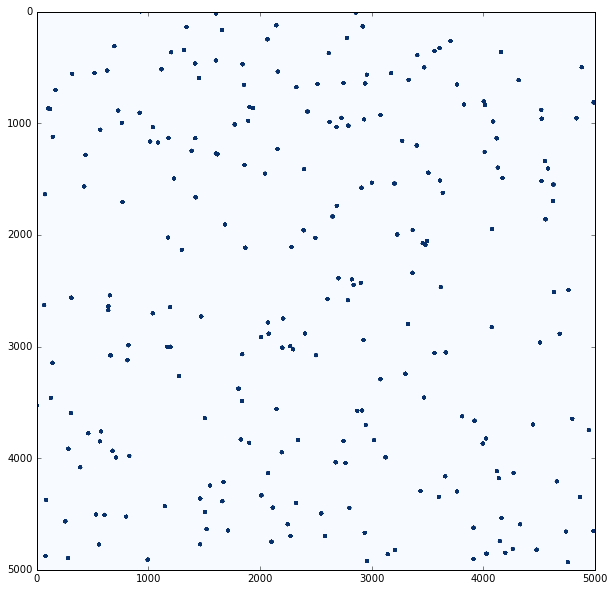

In [11]:
img1_array = pilImage_2_numpyArray(img1)
img1_mono = rgbArray_2_mono(img1_array,'B')

plt.imshow(img1_mono,cmap='Blues')
print "Catalog A:"
print "----------"
print df1

Catalog B:
----------
      ID   r     x     y
0      1  20  3781   647
1      2  20  1845  3088
2      3  20  2090  4742
3      4  20  4812   932
4      5  20  1149  1129
5      6  20  3073  3271
6      7  20  3953  3666
7      8  20   820  3984
8      9  20  4029  3800
9     10  20  3921  4656
10    11  20  2694  1765
11    12  20  1831  3289
12    13  20  3337  1950
13    14  20  2905   201
14    15  20  1008  1183
15    16  20   402  1279
16    17  20   697  4003
17    18  20   937  3436
18    19  20  4742  4913
19    20  20  4690  2884
20    21  20  4913  3718
21    22  20  3479  2069
22    23  20  2677  1031
23    24  20  4022  1260
24    25  20   910   889
25    26  20  2412  1246
26    27  20  2709   663
27    28  20  1501  2209
28    29  20  4114  4090
29    30  20  2297  3031
..   ...  ..   ...   ...
220  221  20  2388  1938
221  222  20  1168   391
222  223  20  2102  4496
223  224  20  4629  2537
224  225  20  1867  2116
225  226  20  2042  2789
226  227  20  2888   985
227

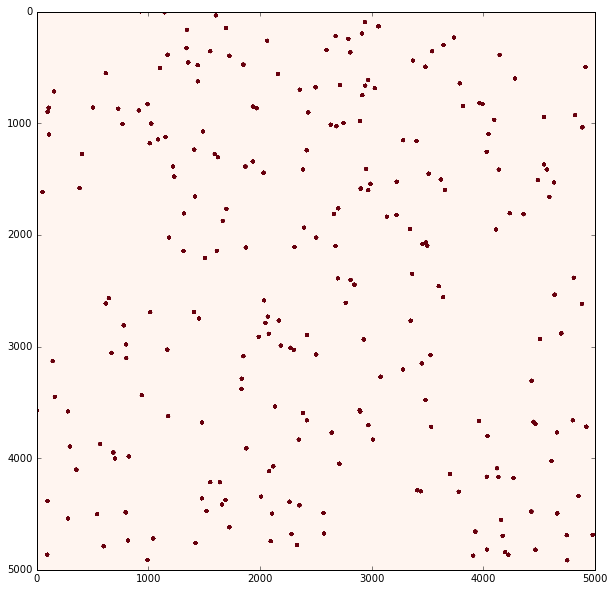

In [12]:
img2_array = pilImage_2_numpyArray(img2)
img2_mono = rgbArray_2_mono(img2_array,'R')

print "Catalog B:"
print "----------"
print df2
plt.imshow(img2_mono,cmap='Reds')

In [13]:
def add_arrays_2_image(img1,img2):
    """
    """
    def array_2_image(arr):
        from PIL import Image
        imgout = Image.fromarray(numpy.uint8(arr))
        return imgout
    return array_2_image(img1+img2)


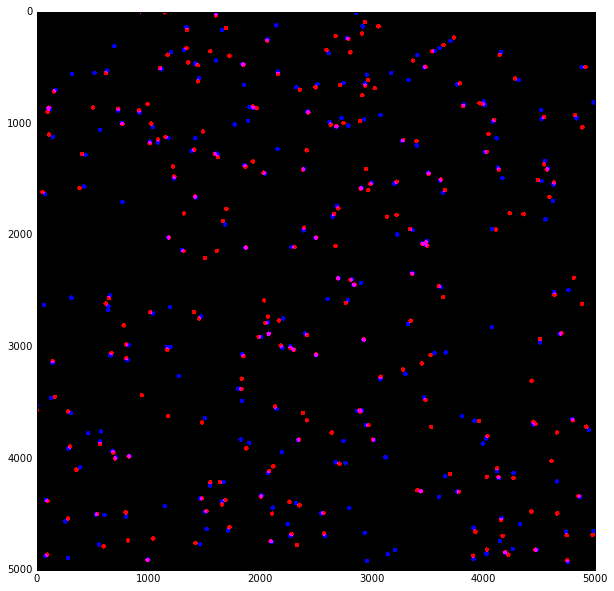

In [14]:
img_sum = add_arrays_2_image(img1_array,img2_array)
plt.imshow(img_sum)

In [15]:
def nn_search(catA,catB, dview=None):
    """
    """
    
    import pandas
    assert isinstance(catA,pandas.DataFrame)
    assert isinstance(catB,pandas.DataFrame)
    
    A = catA.copy()
    B = catB.copy()
    
    from astropy.coordinates import SkyCoord
    from astropy import units
    norm_fact = 500.0
    Ax_norm = A.x / norm_fact
    Ay_norm = A.y / norm_fact
    A_coord = SkyCoord(ra=Ax_norm, dec=Ay_norm, unit=units.deg)

    Bx_norm = B.x / norm_fact
    By_norm = B.y / norm_fact
    B_coord = SkyCoord(ra=Bx_norm, dec=By_norm, unit=units.deg)

    if dview:
        print "Running in parallel"
        # Encapsulate some variables to sand for processing
        def make_nn_search_parallel(foo,cat2):
            def pkg_nn_search(cat1,foo=foo,cat2=cat2):
                return foo(cat1,cat2)
            return pkg_nn_search

        # A-B
        from astropy.coordinates import match_coordinates_sky
        match_eps = make_nn_search_parallel(match_coordinates_sky,B_coord)
        #
        from numpy import arange,array_split,append
        A_list = [ A_coord[idx] for idx in array_split(arange(len(A_coord)),len(dview)) ]
        A_list_out = dview.map_sync(match_eps, A_list)
        #
        match_A_nn_idx, match_A_nn_sep = None, None
        for each_out in A_list_out:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_A_nn_idx is None:
                assert match_A_nn_sep is None
                match_A_nn_idx = match_idx
                match_A_nn_sep = match_sep.value
            else:
                match_A_nn_idx = append(match_A_nn_idx,match_idx)
                match_A_nn_sep = append(match_A_nn_sep,match_sep.value)

        # B-A
        from astropy.coordinates import match_coordinates_sky
        match_eps = make_nn_search_parallel(match_coordinates_sky,A_coord)
        #
        from numpy import arange,array_split,append
        B_list = [ B_coord[idx] for idx in array_split(arange(len(B_coord)),len(dview)) ]
        B_list_out = dview.map_sync(match_eps, B_list)
        #
        match_B_nn_idx, match_B_nn_sep = None, None
        for each_out in B_list_out:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_B_nn_idx is None:
                assert match_B_nn_sep is None
                match_B_nn_idx = match_idx
                match_B_nn_sep = match_sep.value
            else:
                match_B_nn_idx = append(match_B_nn_idx,match_idx)
                match_B_nn_sep = append(match_B_nn_sep,match_sep.value)
        
    else:
        print "Running in serial"
        from astropy.coordinates import match_coordinates_sky
        match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord, B_coord)
        match_B_nn_idx, match_B_nn_sep, _d3d = match_coordinates_sky(B_coord, A_coord)
        match_A_nn_sep = match_A_nn_sep.value
        match_B_nn_sep = match_B_nn_sep.value

    A['NN_in_B'] = B.ID[match_A_nn_idx].values
    B['NN_in_A'] = A.ID[match_B_nn_idx].values

    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                              numpy.arange(len(match_B_nn_idx))))

    duplicate_pairs = []
    duplicate_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            duplicate_pairs.append(p)
            duplicate_dists.append(match_A_nn_sep[i])

    A_matched_idx,B_matched_idx = zip(*duplicate_pairs)
    import pandas
    df_matched = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                    'B_idx':B_matched_idx,
                                    'separation':duplicate_dists})
    df_matched = df_matched.set_index('A_idx')

    A.columns = [ 'A_'+c for c in A.columns ]
    B.columns = [ 'B_'+c for c in B.columns ]

    B_matched = B.iloc[df_matched.B_idx]
    B_matched['A_idx'] = df_matched.index
    B_matched = B_matched.set_index('A_idx')

    B_matched['dist'] = numpy.asarray(df_matched.separation * norm_fact, dtype=int)

    df = pandas.concat([A,B_matched],axis=1)
    return df


In [22]:
%time df_match_serial = nn_search(df1,df2)
# from astropy.table import Table
# table_match = Table.from_pandas( df_match )
# table_match.show_in_notebook()

Running in serial
CPU times: user 360 ms, sys: 17.7 ms, total: 378 ms
Wall time: 348 ms


/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
# Lets us see what happens in parallel
# First, run from the command line:
#$ ipcluster start -n 2
import ipyparallel as ipp
client = ipp.Client()
client.ids
dview = client[:]

In [24]:
%time df_match_parallel = nn_search(df1,df2,dview)

Running in parallel
CPU times: user 415 ms, sys: 35.8 ms, total: 450 ms
Wall time: 532 ms


/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
df_match_parallel.equals(df_match_serial)

True